In [1]:
from collections import namedtuple
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

# 横型ブラインドの斜入射特性を計算するモジュール

スラット材の形状とスラットの日射反射率から任意のプロファイル角における横型ブラインドの日射透過率及び日射反射率を計算する。

### 入力値  

$ W $ ：スラット幅 (m)  
$ d $ ：スラット高さ (m)  
$ S $ ：スラット間隔 (m)  
$ \rho_{upper,S} $：スラット材上面の日射反射率（鏡面反射成分）  
$ \rho_{upper,D} $：スラット材上面の日射反射率（拡散反射成分）  
$ \rho_{lower,S} $：スラット材下面の日射反射率（鏡面反射成分）  
$ \rho_{lower,D} $：スラット材下面の日射反射率（拡散反射成分）  
$ \psi $：スラット角 (°)  
$ \phi $：プロファイル角 (°)  

### 出力値
$ \tau_{\phi,f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$の日射透過率  
$ \tau_{\phi,b} $ ：横型ブラインドの背面側からの入射光に対するプロファイル角$\phi$の日射透過率  
$ \rho_{\phi,f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$の日射反射率  
$ \rho_{\phi,b} $ ：横型ブラインドの背面側からの入射光に対するプロファイル角$\phi$の日射反射率

### 計算方法  

#### データ構造と値の範囲  

$ W $・$ d $・$ S $・$ \rho_{upper,S} $・$ \rho_{upper,D} $・$ \rho_{lower,S} $・$ \rho_{lower,D} $・$ \psi $・$ \phi $の組み合わせをクラス『hbl＿input』と定義する。  
$ \rho_{upper,S} $・$ \rho_{upper,D} $・$ \rho_{lower,S} $・$ \rho_{lower,D} $の値は0.0以上1.0以下の値をとる。  
$ \psi $・$ \phi $の値は-90°以上90°以下の値をとる。  

In [2]:
class hbl_input():
    def __init__( self, W, d, S, REFUS, REFUD, REFLS, REFLD, psi, phi ):
        self.W = W
        self.d = d
        self.S = S
        self.REFUS = REFUS
        self.REFUD = REFUD
        self.REFLS = REFLS
        self.REFLD = REFLD
        self.psi = psi
        self.phi = phi

# W：スラット幅 (mm)
# d：スラット高さ (mm) 
# S：スラット間隔 (mm) 
# REFUS：スラット材上面の日射反射率（鏡面反射成分）
# REFUD：スラット材上面の日射反射率（拡散反射成分）
# REFLS：スラット材下面の日射反射率（鏡面反射成分）
# REFLD：スラット材下面の日射反射率（拡散反射成分）
# psi：スラット角 (°) 
# phi：プロファイル角 (°)

### 1. 鏡面反射

スラット材の鏡面反射成分の光線追跡計算方法を以下に示す。  

（参考：JIS A 2103：2014 附属書C ブラインドの光学特性の計算方法）  

![image4.png][attached1]
[attached1]:img\image4.png  

#### 入射日射（$l = 0$）の位置ベクトル、方向ベクトル、入射日射熱量  

入射開口DA間の分割要素$m$（$0$～$M-1$）からの入射日射の始点の位置ベクトル$ \boldsymbol{p}_{(0)} $は、

$$ 
\displaystyle \boldsymbol{p}_{m,(0)} = 
\begin{pmatrix} 
\displaystyle 0 \\
\displaystyle (m + 0.5) \frac{S}{M} \\
\end{pmatrix} 
\qquad\qquad\text{(1)}
$$

入射開口DA間の分割要素$m$（$0$～$M-1$）からの入射日射の方向ベクトル$ \boldsymbol{s}_{(0)} $は、

$$ 
\displaystyle \boldsymbol{s}_{m,(0)} = 
\begin{pmatrix} 
\displaystyle \cos\phi \\
\displaystyle -\sin\phi \\
\end{pmatrix} 
\qquad\qquad\text{(2)}
$$

入射開口DA間の分割要素$m$（$0$～$M-1$）からの入射日射熱量$ Q_{m,(0)} $は、

$$
\begin{eqnarray}
 &\displaystyle Q_{m,(0)} = I \cdot \cos \phi \cdot \Delta L_{m}& \qquad\qquad\text{(3)} \nonumber\\
\end{eqnarray}
$$

#### 光線の始点の位置ベクトルの計算  

光線の始点の位置ベクトル$ \boldsymbol{p}_{(l)} $の計算式  

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{p}_{(l)} = \boldsymbol{p}_{(l-1)} + a \cdot \boldsymbol{s}_{(l-1)} = \boldsymbol{q}_{(i)} + b \cdot \boldsymbol{v}_{(i)}& \qquad\qquad\text{(4)} \nonumber\\
\end{eqnarray}
$$

式(4)の関係より、

$$ 
\begin{pmatrix} 
\displaystyle s_{(l-1),x}& -v_{(i),x} \\
\displaystyle s_{(l-1),y}& -v_{(i),y} \\
\end{pmatrix}
\begin{pmatrix} 
\displaystyle a \\
\displaystyle b \\
\end{pmatrix}
=
\begin{pmatrix} 
\displaystyle q_{(i),x} - p_{(l-1),x} \\
\displaystyle q_{(i),y} - p_{(l-1),y} \\
\end{pmatrix}
\qquad\qquad\text{(5)}
$$

$$
\begin{eqnarray}
 &\displaystyle a = \frac{-(q_{(i),x}-p_{(l-1),x})v_{(i),y} + v_{(i),x}(q_{(i),y}-p_{(l-1),y})}{-s_{(l-1),x}v_{(i),y} + v_{(i),x} s_{(l-1),y}}& \qquad\qquad\text{(6)} \nonumber\\
\end{eqnarray}
$$

$$
\begin{eqnarray}
 &\displaystyle b = \frac{s_{(l-1),x}(q_{(i),y}-p_{(l-1),y}) - (q_{(i),x} - p_{(l-1),x})s_{(l-1),y}}{-s_{(l-1),x}v_{(i),y} + v_{(i),x} s_{(l-1),y}}& \qquad\qquad\text{(7)} \nonumber\\
\end{eqnarray}
$$

#### 光線の方向ベクトルの計算  

光線の方向ベクトル$ \boldsymbol{s}_{(l)} $の計算式  

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{s}_{(l)} = - \boldsymbol{s}_{(l-1)} + 2 \frac{\boldsymbol{s}_{(l-1)} \cdot \boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|} \frac{\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|}& \qquad\qquad\text{(8)} \nonumber\\
\end{eqnarray}
$$

（式(8)の補足説明）  

$$
\begin{eqnarray}
 &\displaystyle c = \bigl|\boldsymbol{s}_{(l-1)}\bigr| \cos \xi& \qquad\qquad\text{(8-1)} \nonumber\\
\end{eqnarray}
$$

内積の関係より、

$$
\begin{eqnarray}
 &\displaystyle \cos \xi = \frac{\boldsymbol{s}_{(l-1)}\cdot \boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{s}_{(l-1)}\bigr|\bigl|\boldsymbol{v}_{(i)}\bigr|}& \qquad\qquad\text{(8-2)} \nonumber\\
\end{eqnarray}
$$

式(8-1)と式(8-2)より、

$$
\begin{eqnarray}
 &\displaystyle c = \frac{\boldsymbol{s}_{(l-1)} \cdot \boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|}& \qquad\qquad\text{(8-3)} \nonumber\\
\end{eqnarray}
$$

次に、  

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{s}_{(l)} = -\boldsymbol{s}_{(l-1)} + 2c\frac{\boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{v}_{(i)}\bigr|}& \qquad\qquad\text{(8-4)} \nonumber\\
\end{eqnarray}
$$

式(8-3)と式(8-4)より、式(8)が得られる。  

![image3.png][attached1]
[attached1]:img\image3.png  

#### 透過率と反射率の計算  

鏡面反射に対する透過率$ \tau_{dir,S}$の計算式  

$$
\begin{eqnarray}
 &\displaystyle \tau_{dir,S} = \frac{\sum^{M-1}_{m=0}Q_{m,(BC)}}{\sum^{M-1}_{m=0}Q_{m,(0)}}& \qquad\qquad\text{(9)} \nonumber\\
\end{eqnarray}
$$

鏡面反射に対する反射率$ \rho_{dir,S}$の計算式  

$$
\begin{eqnarray}
 &\displaystyle \rho_{dir,S} = \frac{\sum^{M-1}_{m=0}Q_{m,(DA)}}{\sum^{M-1}_{m=0}Q_{m,(0)}}& \qquad\qquad\text{(10)} \nonumber\\
\end{eqnarray}
$$

光線$m$がスラット上面に$L_{m,upper,S}$回、スラット下面に$L_{m,lower,S}$回反射してBC間に到達した場合、

$$
\begin{eqnarray}
 &Q_{m,(BC)} = G_{m, \tau}\:\rho_{upper,S}^{L_{m,upper,S}}\:\rho_{lower,S}^{L_{m,lower,S}}\:Q_{m,(0)}& \qquad\qquad\text{(11)} \nonumber\\
\end{eqnarray}
$$

ここで、  

光線$m$がBC間に到達した場合、$G_{m, \tau}=1$  

それ以外の場合、$G_{m, \tau}=0$ 

光線$m$がスラット上面に$L_{m,upper,S}$回、スラット下面に$L_{m,lower,S}$回反射してDA間に到達した場合、

$$
\begin{eqnarray}
 &Q_{m,(DA)} = G_{m, \rho}\:\rho_{upper,S}^{L_{m,upper,S}}\:\rho_{lower,S}^{L_{m,lower,S}}\:Q_{m,(0)}& \qquad\qquad\text{(12)} \nonumber\\
\end{eqnarray}
$$

ここで、  

光線$m$がDA間に到達した場合、$G_{m, \rho}=1$  

それ以外の場合、$G_{m, \rho}=0$ 

In [17]:
def specular_reflection(L, M, q, v, lmax, sK):

    l = 0 #反射回数
    p = np.empty((M, lmax, 2), dtype=object) #光線の始点の位置ベクトル
    s = np.empty((M, lmax, 2), dtype=object) #光線の方向ベクトル
    ipi = np.empty((M, lmax), dtype=int)
    L_upper = np.zeros(M) #スラット上面での反射回数
    L_lower = np.zeros(M) #スラット下面での反射回数
    G = np.empty((M, 2))  #光線到達面の判断
    while l <= 10 and not (s[:,l-1] == 0).all():
        for m in range(M):
            if l == 0:
                p[m][l] = [0, (m + 0.5) * L.S / M]                                #式(1)、日射の始点の位置ベクトル(0回目)            
                s[m][l] = [np.cos(np.deg2rad(L.phi)), -np.sin(np.deg2rad(L.phi))] #式(2)、日射の方向ベクトル(0回目)
            elif l > 0:
                #日射の方向ベクトル(1回目以降)
                if (sK[2] <= ipi[m][l-1] and ipi[m][l-1] < (sK[3])):
                    G[m][0] = 1 #透過
                    s[m][l] = 0
                elif  (sK[6] <= ipi[m][l-1] and ipi[m][l-1] < (sK[7] - 1)):
                    G[m][1] = 1 #反射
                    s[m][l] = 0
                else:
                    s[m][l] = -s[m][l-1] + 2 * np.vdot(s[m][l-1], v[ipi[m][l-1]]) * v[ipi[m][l-1]] / \
                              (v[ipi[m][l-1]][0] ** 2. + v[ipi[m][l-1]][1] ** 2.) #式(8)

        for m in range(M):
            for i in range(sK[len(sK) - 1] - 1):
                if (s[m][l] == 0).all(): #光線の方向ベクトルが0であれば動かないので
                    p[m][l + 1] = p[m][l]
                    ipi[m][l] = ipi[m][l-1]
                else:
                    if l == 0 or (l > 0 and i != ipi[m][l-1]): #反射回数が0回または0回でない場合には同じ微小要素には帰らないことを示す
                        deno = -s[m][l][0] * v[i][1] + v[i][0] * s[m][l][1]
                        if deno != 0:
                            a = (-(q[i][0] - p[m][l][0]) * v[i][1] + v[i][0] * (q[i][1] - p[m][l][1])) / deno #式(6)
                            b = (s[m][l][0] * (q[i][1] - p[m][l][1]) - (q[i][0] - p[m][l][0]) * s[m][l][1]) / deno #式(7)

                            if 0 < a and 0 <= b and b < 1:
                                p[m][l + 1] = q[i] + b * v[i]
                                ipi[m][l] = i #ipi[m][l]は光線mがどの微小境界要素にたどり着いたか判断
                                
                                if i < sK[0]:                  L_lower[m] += 1 #AB間の下面
                                elif sK[0] <= i and i < sK[1]: L_upper[m] += 1 #AB間の上面
                                elif sK[1] <= i and i < sK[2]: L_lower[m] += 1 #AB間の下面
                                elif sK[3] <= i and i < sK[4]: L_upper[m] += 1 #CD間の上面
                                elif sK[4] <= i and i < sK[5]: L_lower[m] += 1 #CD間の下面
                                elif sK[5] <= i and i < sK[6]: L_upper[m] += 1 #CD間の上面
                                    
        l += 1 #反射回数の追加

    attenuation = np.zeros(M)
    for m in range(M):
        attenuation[m] = L.REFUS ** L_upper[m] * L.REFLS ** L_lower[m] #全入射光線の減衰率

    tau_tot = 0.
    rho_tot = 0.
    for m in range(M):
        tau_tot += attenuation[m] * G[m][0] / M #透過
        rho_tot += attenuation[m] * G[m][1] / M #反射

    return tau_tot, rho_tot, p, s, l

### 2. 拡散反射

スラット材の拡散反射成分の光線追跡計算方法を以下に示す。  

（参考：JIS A 2103：2014 附属書C ブラインドの光学特性の計算方法）  

![image4.png][attached1]
[attached1]:img\image4.png  

#### 入射日射（$l = 0$）の位置ベクトル、方向ベクトル、入射日射熱量  

入射開口DA間の分割要素$m$（$0$～$M-1$）からの入射日射の始点の位置ベクトル$ \boldsymbol{p}_{(0)} $は、

$$ 
\displaystyle \boldsymbol{p}_{m,(0)} = 
\begin{pmatrix} 
\displaystyle 0 \\
\displaystyle (m + 0.5) \frac{S}{M} \\
\end{pmatrix} 
\qquad\qquad\text{(1)}
$$

入射開口DA間の分割要素$m$（$0$～$M-1$）からの入射日射の方向ベクトル$ \boldsymbol{s}_{(0)} $は、

$$ 
\displaystyle \boldsymbol{s}_{m,(0)} = 
\begin{pmatrix} 
\displaystyle \cos\phi \\
\displaystyle -\sin\phi \\
\end{pmatrix} 
\qquad\qquad\text{(2)}
$$

入射開口DA間の分割要素$m$（$0$～$M-1$）からの入射日射熱量$ Q_{m,(0)} $は、

$$
\begin{eqnarray}
 &\displaystyle Q_{m,(0)} = I \cdot \cos \phi \cdot \Delta L_{m}& \qquad\qquad\text{(3)} \nonumber\\
\end{eqnarray}
$$

ここで、

$$
\begin{eqnarray}
 &\displaystyle I = 1& \qquad\qquad\text{(4)} \nonumber\\
\end{eqnarray}
$$

$$
\begin{eqnarray}
 &\displaystyle \Delta L_{m} = \frac{S}{M}& \qquad\qquad\text{(5)} \nonumber\\
\end{eqnarray}
$$

#### 光線の始点の位置ベクトルの計算  

光線の始点の位置ベクトル$ \boldsymbol{p}_{(l)} $の計算式  

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{p}_{(l)} = \boldsymbol{p}_{(l-1)} + a \cdot \boldsymbol{s}_{(l-1)} = \boldsymbol{q}_{(i)} + b \cdot \boldsymbol{v}_{(i)}& \qquad\qquad\text{(6)} \nonumber\\
\end{eqnarray}
$$

式(4)の関係より、

$$ 
\begin{pmatrix} 
\displaystyle s_{(l-1),x}& -v_{(i),x} \\
\displaystyle s_{(l-1),y}& -v_{(i),y} \\
\end{pmatrix}
\begin{pmatrix} 
\displaystyle a \\
\displaystyle b \\
\end{pmatrix}
=
\begin{pmatrix} 
\displaystyle q_{(i),x} - p_{(l-1),x} \\
\displaystyle q_{(i),y} - p_{(l-1),y} \\
\end{pmatrix}
\qquad\qquad\text{(7)}
$$

$$
\begin{eqnarray}
 &\displaystyle a = \frac{-(q_{(i),x}-p_{(l-1),x})v_{(i),y} + v_{(i),x}(q_{(i),y}-p_{(l-1),y})}{-s_{(l-1),x}v_{(i),y} + v_{(i),x} s_{(l-1),y}}& \qquad\qquad\text{(8)} \nonumber\\
\end{eqnarray}
$$

$$
\begin{eqnarray}
 &\displaystyle b = \frac{s_{(l-1),x}(q_{(i),y}-p_{(l-1),y}) - (q_{(i),x} - p_{(l-1),x})s_{(l-1),y}}{-s_{(l-1),x}v_{(i),y} + v_{(i),x} s_{(l-1),y}}& \qquad\qquad\text{(9)} \nonumber\\
\end{eqnarray}
$$

直接受照日射量$E_{d,i}$は、

$$
\begin{eqnarray}
 &\displaystyle E_{d,i} = \sum^{M-1}_{m=0} \frac {Q_{m,(0)} \sin \xi_{i}}{\Delta L_{i}}& \qquad\qquad\text{(10)} \nonumber\\
\end{eqnarray}
$$

ここで、

$$
\begin{eqnarray}
 &\displaystyle \xi_{i} = \arccos \frac{\boldsymbol{s}_{(0)}\cdot \boldsymbol{v}_{(i)}}{\bigl|\boldsymbol{s}_{(0)}\bigr|\bigl|\boldsymbol{v}_{(i)}\bigr|}& \qquad\qquad\text{(11)} \nonumber\\
\end{eqnarray}
$$

$$
\begin{eqnarray}
 &\displaystyle \Delta L_{i} = \bigl|\boldsymbol{v}_{(i)}\bigr|& \qquad\qquad\text{(12)} \nonumber\\
\end{eqnarray}
$$

![image3.png][attached1]
[attached1]:img\image3.png  

間接受照日射量$E_{r,i}$は、

$$
\begin{eqnarray}
 &\displaystyle E_{r,i} \Delta L_{i} = \sum^{K-1}_{j=0} F_{ji}\rho_{j} (E_{r,j} + E_{d,j}) \Delta L_j& \qquad\qquad\text{(13)} \nonumber\\
\end{eqnarray}
$$

形態係数の相反則より、

$$
\begin{eqnarray}
 &\displaystyle \Delta L_{i} F_{ij} = \Delta L_{j} F_{ji}& \qquad\qquad\text{(14)} \nonumber\\
\end{eqnarray}
$$

式(13)と式(14)より、

$$
\begin{eqnarray}
 &\displaystyle E_{r,i} = \sum^{K-1}_{j=0} F_{ij}\rho_{j} E_{r,j} + \sum^{K-1}_{j=0} F_{ij}\rho_{j} E_{d,j}& \qquad\qquad\text{(15)} \nonumber\\
\end{eqnarray}
$$

しｋ

In [4]:
def diffuse_reflection(L, M, q, v, lmax, sK):
    
    Q = np.empty((M, lmax), dtype=object) #入射開口DA間の分割要素mからの入射日射熱量(W/m)
    
    #l = 0 #反射回数
    p = np.empty((M, lmax, 2), dtype=object) #光線の始点の位置ベクトル
    s = np.empty((M, lmax, 2), dtype=object) #光線の方向ベクトル
    ipi = np.empty((M, lmax), dtype=int)
    #L_upper = np.zeros(M) #スラット上面での反射回数
    #L_lower = np.zeros(M) #スラット下面での反射回数
    #G = np.empty((M, 2))  #光線到達面の判断
    #while l <= 10 and not (s[:,l-1] == 0).all():

    I = 1.
    Ed = np.empty((sK[len(sK) - 1] - 1), dtype=object)
    
    for l in range(2):
        for m in range(M):
            if l == 0:
                p[m][l] = [0, (m + 0.5) * L.S / M]                                #式(1)、日射の始点の位置ベクトル(0回目)            
                s[m][l] = [np.cos(np.deg2rad(L.phi)), -np.sin(np.deg2rad(L.phi))] #式(2)、日射の方向ベクトル(0回目)
                dLm[m] = L.S / M
                Q[m][l] = I * np.cos(np.deg2rad(L.phi)) * dLm[m]

                for i in range(sK[len(sK) - 1] - 1): #0番目の分割要素から最後の分割要素まで
                    xi[i] = np.rad2deg(np.arccos(np.vdot(s[m][l], v[i]) / \
                            ((s[m][l][0] ** 2. + s[m][l][1] ** 2.) ** 0.5 * (v[i][0] ** 2. + v[i][1] ** 2.) ** 0.5))) #式(9)
                    
                    dLi[i] = (v[i][0] ** 2. + v[i][1] ** 2.) ** 0.5 #式(10)         
                    
                    deno = -s[m][l][0] * v[i][1] + v[i][0] * s[m][l][1]
                    if deno != 0:
                        a = (-(q[i][0] - p[m][l][0]) * v[i][1] + v[i][0] * (q[i][1] - p[m][l][1])) / deno #式(6)
                        b = (s[m][l][0] * (q[i][1] - p[m][l][1]) - (q[i][0] - p[m][l][0]) * s[m][l][1]) / deno #式(7)

                        if 0 < a and 0 <= b and b < 1:
                            #p[m][l + 1] = q[i] + b * v[i]
                            ipi[m][l] = i #ipi[m][l]は光線mがどの微小境界要素にたどり着いたか判断 
                            Ed[i] += Q[m][l] * np.sin(np.deg2rad(xi[i])) / dLi[i]
                            
                
                
   #ここまで             
            elif l == 1:
                if (sK[2] <= ipi[m][l-1] and ipi[m][l-1] < (sK[3])):
                    G[m][0] = 1 #透過
                    s[m][l] = 0
                #elif  (sK[6] <= ipi[m][l-1] and ipi[m][l-1] < (sK[7] - 1)):
                #    G[m][1] = 1 #反射
                #    s[m][l] = 0
                else:
                    s[m][l] = -s[m][l-1] + 2 * np.vdot(s[m][l-1], v[ipi[m][l-1]]) * v[ipi[m][l-1]] / \
                              (v[ipi[m][l-1]][0] ** 2. + v[ipi[m][l-1]][1] ** 2.) #式(8)
                        

                
##########################

    while l <= 10 and not (s[:,l-1] == 0).all():
        for m in range(M):
            if l == 0:
                p[m][l] = [0, (m + 0.5) * L.S / M]                                #式(1)、日射の始点の位置ベクトル(0回目)            
                s[m][l] = [np.cos(np.deg2rad(L.phi)), -np.sin(np.deg2rad(L.phi))] #式(2)、日射の方向ベクトル(0回目)
            elif l > 0:
                #日射の方向ベクトル(1回目以降)
                if (sK[2] <= ipi[m][l-1] and ipi[m][l-1] < (sK[3])):
                    G[m][0] = 1 #透過
                    s[m][l] = 0
                elif  (sK[6] <= ipi[m][l-1] and ipi[m][l-1] < (sK[7] - 1)):
                    G[m][1] = 1 #反射
                    s[m][l] = 0
                else:
                    s[m][l] = -s[m][l-1] + 2 * np.vdot(s[m][l-1], v[ipi[m][l-1]]) * v[ipi[m][l-1]] / \
                              (v[ipi[m][l-1]][0] ** 2. + v[ipi[m][l-1]][1] ** 2.) #式(8)

        for m in range(M):
            for i in range(sK[len(sK) - 1] - 1):
                if (s[m][l] == 0).all(): #光線の方向ベクトルが0であれば動かないので
                    p[m][l + 1] = p[m][l]
                    ipi[m][l] = ipi[m][l-1]
                else:
                    if l == 0 or (l > 0 and i != ipi[m][l-1]): #反射回数が0回または0回でない場合には同じ微小要素には帰らないことを示す
                        deno = -s[m][l][0] * v[i][1] + v[i][0] * s[m][l][1]
                        if deno != 0:
                            a = (-(q[i][0] - p[m][l][0]) * v[i][1] + v[i][0] * (q[i][1] - p[m][l][1])) / deno #式(6)
                            b = (s[m][l][0] * (q[i][1] - p[m][l][1]) - (q[i][0] - p[m][l][0]) * s[m][l][1]) / deno #式(7)

                            if 0 < a and 0 <= b and b < 1:
                                p[m][l + 1] = q[i] + b * v[i]
                                ipi[m][l] = i #ipi[m][l]は光線mがどの微小境界要素にたどり着いたか判断
                                
                                if i < sK[0]:                  L_lower[m] += 1 #AB間の下面
                                elif sK[0] <= i and i < sK[1]: L_upper[m] += 1 #AB間の上面
                                elif sK[1] <= i and i < sK[2]: L_lower[m] += 1 #AB間の下面
                                elif sK[3] <= i and i < sK[4]: L_upper[m] += 1 #CD間の上面
                                elif sK[4] <= i and i < sK[5]: L_lower[m] += 1 #CD間の下面
                                elif sK[5] <= i and i < sK[6]: L_upper[m] += 1 #CD間の上面
                                    
        l += 1 #反射回数の追加

######################

    return tau_tot, rho_tot

### 3. 領域境界分割要素の位置ベクトルと方向ベクトル

#### スラット端点と中央点の位置

点A(下スラットの左端点)、点B(下スラットの右端点)、点C(上スラットの右端点)、点D(上スラットの左端点)、点E(下スラットの中央点)、点F(上スラットの中央点)の位置ベクトルは、

![image4.png][attached1]
[attached1]:img\image4.png  

$$ 
\displaystyle \boldsymbol{A} = 
\begin{pmatrix} 
\displaystyle 0 \\
\displaystyle 0 \\
\end{pmatrix} 
\qquad\qquad\text{(1)}
$$

$$ 
\displaystyle \boldsymbol{B} = 
\begin{pmatrix} 
\displaystyle W\cos\psi \\
\displaystyle W\sin\psi \\
\end{pmatrix} 
\qquad\qquad\text{(2)}
$$

$$ 
\displaystyle \boldsymbol{C} = 
\begin{pmatrix} 
\displaystyle B_{x} \\
\displaystyle B_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(3)}
$$

$$ 
\displaystyle \boldsymbol{D} = 
\begin{pmatrix} 
\displaystyle A_{x} \\
\displaystyle A_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(4)}
$$

平板スラット($d=0$)の場合、

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{E} = \frac{\boldsymbol{B} - \boldsymbol{A}}{2}& \qquad\qquad\text{(5)} \nonumber\\
\end{eqnarray}
$$

円弧スラット($d \neq 0$)の場合、

$$ 
\displaystyle \boldsymbol{E} = 
\begin{pmatrix} 
\displaystyle \sqrt{(0.5W)^2 + d^2} \cos\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigl) \\
\displaystyle \sqrt{(0.5W)^2 + d^2} \sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigl) \\
\end{pmatrix} 
\qquad\qquad\text{(6)}
$$

$$ 
\displaystyle \boldsymbol{F} = 
\begin{pmatrix} 
\displaystyle E_{x} \\
\displaystyle E_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(7)}
$$

In [5]:
def slat_edge_position(L):
    
    A = np.array([0., 0.]) #式(1)
    B = np.array([L.W * np.cos(np.deg2rad(L.psi)), L.W * np.sin(np.deg2rad(L.psi))]) #式(2)
    C = np.array([B[0], B[1] + L.S]) #式(3)
    D = np.array([A[0], A[1] + L.S]) #式(4)
    if L.d ==0:
        E = (B - A) / 2. #式(5)
    else:
        E = np.array([((0.5 * L.W) ** 2. + L.d ** 2.) ** 0.5 * np.cos(np.arctan(L.d / (0.5 * L.W)) + np.deg2rad(L.psi)), 
                      ((0.5 * L.W) ** 2. + L.d ** 2.) ** 0.5 * np.sin(np.arctan(L.d / (0.5 * L.W)) + np.deg2rad(L.psi))]) #式(6)
    
    F = np.array([E[0], E[1] + L.S]) #式(7)
    
    return A, B, C, D, E, F

#### 円弧スラットの中心座標、半径、中心角  

円弧スラット($d \neq 0$)の場合、  

円の方程式  

$$
\begin{eqnarray}
 &\displaystyle x^2 + y^2 + l_0x + l_1y + l_2 = 0& \qquad\qquad\text{(1)} \nonumber\\
\end{eqnarray}
$$

式(1)を変形すると、  

$$
\begin{eqnarray}
 &\displaystyle l_0x + l_1y + l_2 = -(x^2 + y^2)& \qquad\qquad\text{(2)} \nonumber\\
\end{eqnarray}
$$

外接円となる点A、点B、点Eの3点の位置ベクトルを式(2)に代入して連立すると、

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{a} \cdot \boldsymbol{l} = \boldsymbol{b}& \qquad\qquad\text{(3)} \nonumber\\
\end{eqnarray}
$$

ここで、

$ 
\displaystyle \boldsymbol{a} = 
\begin{pmatrix} 
\displaystyle 0&\displaystyle 0&\displaystyle 1 \\
\displaystyle W\cos\psi&\displaystyle W\sin\psi&\displaystyle 1 \\
\displaystyle \sqrt{(0.5W)^2 + d^2} \cos\Bigl(\arctan\frac{d}{0.5W} +\psi\Bigr)&\displaystyle \sqrt{(0.5W)^2 + d^2} \sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)&\displaystyle 1 \\
\end{pmatrix} 
$  

$
\displaystyle \boldsymbol{l}
=
\begin{pmatrix} 
\displaystyle l_0 \\
\displaystyle l_1 \\
\displaystyle l_2 \\
\end{pmatrix}
$  

$
\displaystyle \boldsymbol{b}
= 
\begin{pmatrix} 
\displaystyle 0 \\
\displaystyle -(W\cos\psi^2 + \sin\psi^2) \\
\displaystyle -\Biggl(\biggl(\sqrt{(0.5W)^2 + d^2}\cos\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)\biggr)^2 + 
               \biggl(\sqrt{(0.5W)^2 + d^2}\sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)\biggr)^2\Biggr) \\
\end{pmatrix} 
$  

外接円の中心点Oの位置ベクトルは、

$$ 
\displaystyle \boldsymbol{O} = 
\begin{pmatrix} 
\displaystyle -0.5l_0 \\
\displaystyle -0.5l_1 \\
\end{pmatrix}
\qquad\qquad\text{(4)}
$$

外接円の半径$r$は、

$$
\begin{eqnarray}
 &\displaystyle r = \sqrt{(-0.5l_0) ^ 2 + (-0.5l_1) ^ 2 - l_2}& \qquad\qquad\text{(5)} \nonumber\\
\end{eqnarray}
$$

点Aと点Bがなす円弧の中心角$\theta$は、

$$
\begin{eqnarray}
 &\displaystyle \theta = 4 \arctan \frac{d}{0.5W}& \qquad\qquad\text{(6)} \nonumber\\
\end{eqnarray}
$$

In [6]:
#3点を通る外接円の点A、点B、点E及び中心点Oの座標、半径r、中心角θ
def slat_circle(L, A, B, E):
    
    if L.d == 0:
        O = ''
        r = ''
        theta = ''
    else:
        a = np.array([[A[0], A[1], 1.], [B[0], B[1], 1.], [E[0], E[1], 1.]])
        b = -(a[:, 0] ** 2 + a[:, 1] ** 2.)

        a = a.astype(np.float64)
        b = b.astype(np.float64)
        l = np.linalg.solve(a, b) #式(3)

        O =[- 0.5 * l[0], - 0.5 * l[1]] #円弧の原点の位置ベクトル 式(4)
        r = ((- 0.5 * l[0]) ** 2. + (- 0.5 * l[1]) ** 2. - l[2]) ** 0.5 #式(5)
        theta = np.rad2deg(4 * np.arctan(L.d / (0.5 * L.W))) #円弧の中心角 式(6)
    
    return O, r, theta

#### スラットの最端座標  

円弧スラット($d \neq 0$)かつ$ O_{y} > A_{y} $の場合、 

$$ 
\displaystyle \boldsymbol{A}' = 
\begin{pmatrix} 
\displaystyle O_{x} - r \\
\displaystyle O_{y} \\
\end{pmatrix}
\qquad\qquad\text{(1)}
$$

円弧スラット($d \neq 0$)かつ$ O_{y} > B_{y} $の場合、 

$$ 
\displaystyle \boldsymbol{B}' = 
\begin{pmatrix} 
\displaystyle O_{x} + r \\
\displaystyle O_{y} \\
\end{pmatrix}
\qquad\qquad\text{(2)}
$$

その他の場合、

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{A}' = \boldsymbol{A}& \qquad\qquad\text{(3)} \nonumber\\
\end{eqnarray}
$$

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{B}' = \boldsymbol{B}& \qquad\qquad\text{(4)} \nonumber\\
\end{eqnarray}
$$

$$ 
\displaystyle \boldsymbol{C}' = 
\begin{pmatrix} 
\displaystyle B'_{x} \\
\displaystyle B'_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(5)}
$$

$$ 
\displaystyle \boldsymbol{D}' = 
\begin{pmatrix} 
\displaystyle A'_{x} \\
\displaystyle A'_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(6)}
$$

In [7]:
def slat_additional_position(L, O, r, A, B):
    
    if L.d == 0:
        Ad = A
        Bd = B
    else:
        if O[1] > A[1]: #円弧が食い込む
            Ad = np.array([O[0] - r, O[1]]) #点A'の位置
        else:           #円弧が食い込まない
            Ad = A                          #点A'の位置

        if O[1] > B[1]: #円弧が食い込む
            Bd = np.array([O[0] + r, O[1]]) #点B'の位置
        else:           #円弧が食い込まない
            Bd = B                          #点B'の位置
    Cd = np.array([Bd[0], Bd[1] + L.S]) #点C'の位置
    Dd = np.array([Ad[0], Ad[1] + L.S]) #点D'の位置
    
    return Ad, Bd, Cd, Dd

#### 平板スラットの領域境界分割要素の始点の位置ベクトル 

平板スラット($d=0$)の領域境界分割要素の始点の位置ベクトル$\boldsymbol{q}_i$は、次のように表すことができる。  

$0 \leq i \leq K_0$の場合、

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle \frac{i}{K_0} W \cos \psi \\
\displaystyle \frac{i}{K_0} W \sin \psi \\
\end{pmatrix} 
\qquad\qquad\text{(1)}
$$

$K_0 < i \leq (K_0 + K_1)$の場合、  

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle q_{K_0,x} \\
\displaystyle q_{K_0,y} + \frac{i - K_0}{K_1} S \\
\end{pmatrix}
\qquad\qquad\text{(2)}
$$

$(K_0 + K_1) < i \leq (K_0 + K_1 + K_2)$の場合、 

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle q_{(K_0 + K_1),x} - \frac{i - K_0 - K_1 - K_2}{K_2} W\cos\psi \\
\displaystyle q_{(K_0 + K_1),y} - \frac{i - K_0 - K_1 - K_2}{K_2} W\sin\psi \\
\end{pmatrix} 
\qquad\qquad\text{(3)}
$$

$(K_0 + K_1 + K_2) < i \leq (K_0 + K_1 + K_2 + K_3)$の場合、 

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle q_{(K_0 + K_1 + K_2),x} \\
\displaystyle q_{(K_0 + K_1 + K_2),y} - \frac{i - K_0 - K_1 - K_2}{K_3} S \\
\end{pmatrix} 
\qquad\qquad\text{(4)}
$$

In [8]:
#平板スラットの領域境界の分割要素の始点の位置ベクトル
def position_vector_flat_q(L, K):
    
    sK =np.zeros(len(K), dtype=int)
    for i in range(len(K)):
        sK[i] = np.sum(K[:i+1])
    
    q = np.empty((sK[len(K)-1] + 1, 2), dtype=object)
    for i in range(sK[len(K)-1] + 1):
        if L.d == 0: #平板
            if i <= sK[0]:   #A-B間
                q[i] = [i / K[0] * L.W * np.cos(np.deg2rad(L.psi)), 
                        i / K[0] * L.W * np.sin(np.deg2rad(L.psi))]
            elif i <= sK[1]: #B-C間
                q[i] = [q[sK[0]][0], 
                        q[sK[0]][1] + (i - sK[0]) / K[1] * L.S]
            elif i <= sK[2]: #C-D間
                q[i] = [q[sK[1]][0] - (i - sK[1]) / K[2] * L.W * np.cos(np.deg2rad(L.psi)), 
                        q[sK[1]][1] - (i - sK[1]) / K[2] * L.W * np.sin(np.deg2rad(L.psi))]
            elif i <= sK[3]: #D-A間
                q[i] = [q[sK[2]][0], 
                        q[sK[2]][1] - (i - sK[2]) / K[3] * L.S]
                
    Kn = np.array([0, K[0], 0, K[1], 0, K[2], 0, K[3] + 1])

    sKn =np.zeros(len(Kn), dtype=int)
    for i in range(len(Kn)):
        sKn[i] = np.sum(Kn[:i+1])
                             
    return q, sKn#sK[len(K)-1]

#### 円弧スラットの領域境界分割要素の始点の位置ベクトル 

円弧スラット($d \neq 0$)の領域境界分割要素の始点の位置ベクトル$\boldsymbol{q}_i$は、次のように表すことができる。  

$0 \leq i \leq K_0$の場合、

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle O_x - r \cos\Bigl(\arctan\frac{O_y}{O_x} - \frac{i}{K_0} \theta \Bigr) \\
\displaystyle O_y - r \sin\Bigl(\arctan\frac{O_y}{O_x} - \frac{i}{K_0} \theta \Bigr) \\
\end{pmatrix} 
\qquad\qquad\text{(1)}
$$

$K_0 \leq i \leq (K_0 + K_1)$の場合、  

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle q_{K_0,x} \\
\displaystyle q_{K_0,y} + \frac{i - K_0}{K_1} S \\
\end{pmatrix}
\qquad\qquad\text{(2)}
$$

$(K_0 + K_1) \leq i \leq (K_0 + K_1 + K_2)$の場合、 

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle q_{(K_0 + K_1),x} + O_x - r\cos\Bigl(\arctan\frac{O_y}{O_x} + \frac{i - K_0 - K_1 - K_2}{K_2} \theta \Bigr) - W\cos\psi \\
\displaystyle q_{(K_0 + K_1),y} + O_y - r\sin\Bigl(\arctan\frac{O_y}{O_x} + \frac{i - K_0 - K_1 - K_2}{K_2} \theta \Bigr) - W\sin\psi \\
\end{pmatrix} 
\qquad\qquad\text{(3)}
$$

$(K_0 + K_1 + K_2) \leq i \leq (K_0 + K_1 + K_2 + K_3)$の場合、 

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle q_{(K_0 + K_1 + K_2),x} \\
\displaystyle q_{(K_0 + K_1 + K_2),y} - \frac{i - K_0 - K_1 - K_2}{K_3} S \\
\end{pmatrix} 
\qquad\qquad\text{(4)}
$$

In [9]:
#円弧スラットの領域境界の分割要素の始点の位置ベクトル
def position_vector_curve_qd(L, K, O, r, theta, A, B, C, D, Ad, Bd, Cd, Dd):

    qd = np.empty((len(K), max(K) + 1, 2), dtype=object)

    for k in range(len(K)):
        for i in range(K[k] + 1):
            if k == 0: #A-B間
                if O[0] >= A[0]: pns = - 1.
                elif O[0] < A[0]: pns = 1.

                qd[k][i] = [O[0] + pns * r * np.cos((np.arctan(O[1] / O[0])) - np.deg2rad(i / K[0] * theta)), 
                            O[1] + pns * r * np.sin((np.arctan(O[1] / O[0])) - np.deg2rad(i / K[0] * theta))] #式(1)
            
            elif k == 1: #B-C間
                if all(B == Bd): sp = qd[0][K[0]]
                else: sp = Bd

                qd[k][i] = [sp[0], 
                            sp[1] + i / K[1] * L.S] #式(2)
                
            elif k == 2: #C-D間
                if all(C == Cd): sp = qd[1][K[1]]
                else: sp = C

                if O[0] >= A[0]: pns = - 1.
                elif O[0] < A[0]: pns = 1.

                qd[k][i] = [sp[0] + O[0] + pns * r * np.cos((np.arctan(O[1] / O[0])) + \
                            np.deg2rad((i - K[2]) / K[2] * theta)) - L.W * np.cos(np.deg2rad(L.psi)), 
                            sp[1] + O[1] + pns * r * np.sin((np.arctan(O[1] / O[0])) + \
                            np.deg2rad((i - K[2]) / K[2] * theta)) - L.W * np.sin(np.deg2rad(L.psi))] #式(3)
                
            elif k == 3: #D-A間
                if all(D == Dd): sp = qd[2][K[2]]
                else: sp = Dd

                qd[k][i] = [sp[0], 
                            sp[1] - i / K[3] * L.S] #式(4)

    return qd

In [10]:
#領域内・外点の判断(回転角で判断すべきか？？)
def position_specific_qd(L, K, qd, A, B, C, D, Ad, Bd, Cd, Dd):
    
    out_pt = np.zeros(len(qd), dtype=int)
    in_pt = np.zeros(len(qd), dtype=int) 
        
    for k in range(len(K)):
        for i in range(K[k] + 1):
            if k == 0: #A-B間
                if all(A != Ad) and qd[k][i][0] < B[0]:
                    if L.d > 0 and qd[k][i][1] < Ad[1]:
                        out_pt[0] += 1 #点A-A'間の領域外点
                    elif L.d < 0 and qd[k][i][1] > Ad[1]:
                        in_pt[0] += 1  #点A-A'間の領域内点

                if all(B != Bd) and qd[k][i][0] > A[0]:
                    if L.d > 0 and qd[k][i][1] < Bd[1]:
                        out_pt[1] += 1 #点B-B'間の領域外点
                    elif L.d < 0 and qd[k][i][1] > Bd[1]:
                        in_pt[1] += 1  #点B-B'間の領域内点

            if k == 2: #C-D間
                if all(C != Cd) and qd[k][i][0] > D[0]:
                    if L.d > 0 and qd[k][i][1] < Cd[1]:
                        in_pt[2] += 1 #点C-C'間の領域内点
                    elif L.d < 0 and qd[k][i][1] > Cd[1]:
                        out_pt[2] += 1  #点C-C'間の領域外点 
                    
                if all(D != Dd) and qd[k][i][0] < C[0]:
                    if L.d > 0 and qd[k][i][1] < Dd[1]:
                        in_pt[3] += 1 #点D-D'間の領域内点
                    elif L.d < 0 and qd[k][i][1] > Dd[1]:
                        out_pt[3] += 1  #点D-D'間の領域外点
                    
    return out_pt, in_pt

In [11]:
#領域外点の削除・追加
def position_vector_curve_q(L, K, qd, A, B, C, D, Ad, Bd, Cd, Dd, out_pt, in_pt):
    
    Kn = np.array([in_pt[0], K[0] - (out_pt[0] + out_pt[1]), in_pt[1], K[1], 
                   in_pt[2], K[2] - (out_pt[2] + out_pt[3]), in_pt[3], K[3] + 1])

    
    if out_pt[0] != 0 or out_pt[1] != 0: Kn[1] = K[0] + 1 - (out_pt[0] + out_pt[1])
    if out_pt[2] != 0 or out_pt[3] != 0: Kn[6] = K[2] + 1 - (out_pt[2] + out_pt[3])
        
    sKn =np.zeros(len(Kn), dtype=int)
    for i in range(len(Kn)):
        sKn[i] = np.sum(Kn[:i+1])

    qn = np.empty((sKn[len(Kn)-1], 2), dtype=object) 
    
    for i in range(sKn[len(Kn)-1]):
        if i < sKn[0]: #d<0でなければ存在しない
            qn[i] = " "
            
        elif i < sKn[1]: #A-B間
            if out_pt[0] == 0:
                qn[i] = qd[0, i] 
            else:
                if i == 0:
                    qn[i] = Ad
                else:
                    qn[i] = qd[0, i - 1 + out_pt[0]]
            
        elif i < sKn[2]: #d<0でなければ存在しない
            qn[i] = " "
            
        elif i < sKn[3]: #B-C間
            qn[i] = qd[1, i - sKn[2]]
            
        elif i < sKn[4]: #上スラット上面右
            if in_pt[2] != 0:
                if i - sKn[3] == 0:
                    qn[i] = Cd
                else:
                    qn[i] = qd[2, sKn[4] - i]
            
        elif i < sKn[5]: #C-D間
            qn[i] = qd[2, i - sKn[4]]
            
        elif i < sKn[6]: #上スラット上面左
            if in_pt[3] != 0:               
                qn[i] = qd[2, sKn[5] + Kn[5] - i]
            
        elif i < sKn[7]: #D-A間
            qn[i] = qd[3, i - sKn[6]]
            
    for i in range(sKn[len(Kn)-1]):
        qn[i] -= Ad

    return qn, sKn

#### 境界分割要素の方向ベクトル  

領域境界分割要素の方向ベクトル$\boldsymbol{v}_i$は、次のように表すことができる。 

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{v}_i = \boldsymbol{q}_{i+1} - \boldsymbol{q}_i& \qquad\qquad\text{(1)} \nonumber\\
\end{eqnarray}
$$

In [12]:
#領域境界の分割要素の方向ベクトル
def direction_vector(q, sK):
    
    v = np.empty((sK[len(sK) - 1] - 1, 2), dtype=object)
    for i in range(sK[len(sK) - 1] - 1):
        v[i] = q[i + 1] - q[i]
        
    return v

#### Example

40
40
40
40
40


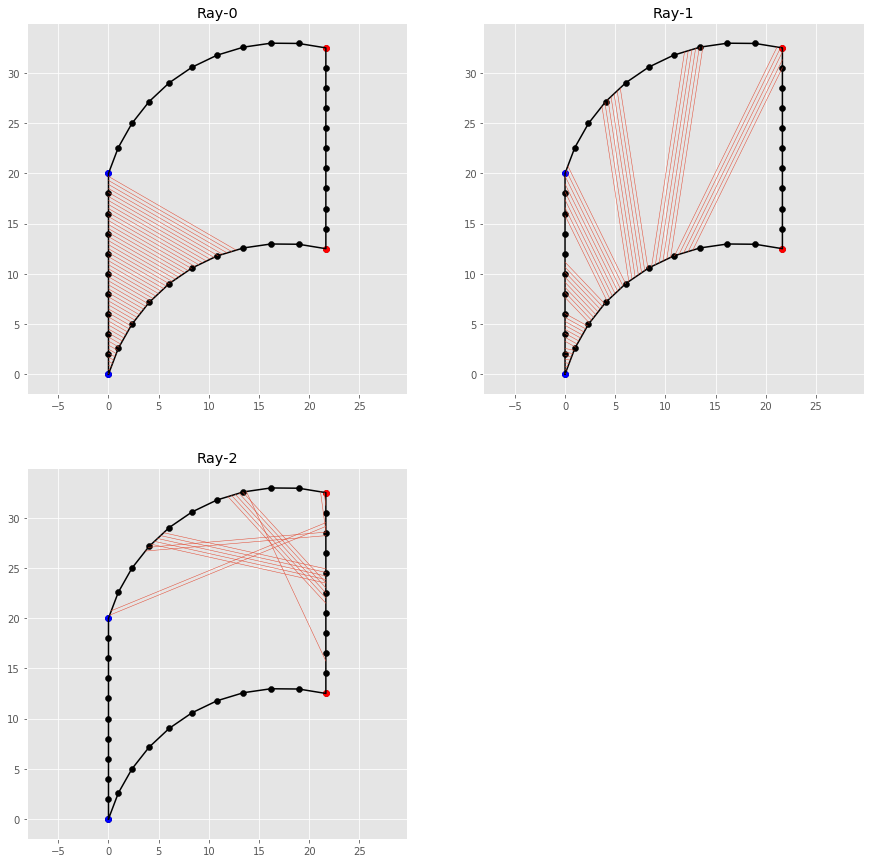

0.1104 0.47200000000000036


In [18]:
if __name__ == '__main__':
    #hbl_input( W, d, S, REFUS, REFUD, REFLS, REFLD, psi, phi )
    hbl = hbl_input( 25., 5., 20., 0.8, 0.8, 0.2, 0.2, 30., 30. )#d<0未考慮, dが大きすぎると下のスラットを貫通する場合がある
    #hbl = hbl_input( 25., 0., 20., 0.8, 0.8, 0.2, 0.2, 70., 30. )

    # W：スラット幅 (mm)
    # d：スラット高さ (mm) 
    # S：スラット間隔 (mm) 
    # REFUS：スラット材上面の日射反射率（鏡面反射成分）
    # REFUD：スラット材上面の日射反射率（拡散反射成分）
    # REFLS：スラット材下面の日射反射率（鏡面反射成分）
    # REFLD：スラット材下面の日射反射率（拡散反射成分）
    # psi：スラット角 (°) 
    # phi：プロファイル角 (°)

    K = np.array([10, 10, 10, 10])       #領域境界の微小線分要素分割数(各境界)
    M = 100                              #入射開口の微小線分要素分割数
    lmax = 100                           #最大反射回数

    A = slat_edge_position(hbl)[0]
    B = slat_edge_position(hbl)[1]
    C = slat_edge_position(hbl)[2]
    D = slat_edge_position(hbl)[3]
    E = slat_edge_position(hbl)[4]
    F = slat_edge_position(hbl)[5]
    
    O = slat_circle(hbl, A, B, E)[0]
    r = slat_circle(hbl, A, B, E)[1]
    theta = slat_circle(hbl, A, B, E)[2]

    Ad = slat_additional_position(hbl, O, r, A, B)[0]
    Bd = slat_additional_position(hbl, O, r, A, B)[1]
    Cd = slat_additional_position(hbl, O, r, A, B)[2]
    Dd = slat_additional_position(hbl, O, r, A, B)[3]

    if hbl.d == 0: 
        q = position_vector_flat_q(hbl, K)[0]
        sK = position_vector_flat_q(hbl, K)[1]
    elif hbl.d != 0:
        qd = position_vector_curve_qd(hbl, K, O, r, theta, A, B, C, D, Ad, Bd, Cd, Dd)

        out_pt = position_specific_qd(hbl, K, qd, A, B, C, D, Ad, Bd, Cd, Dd)[0]
        in_pt = position_specific_qd(hbl, K, qd, A, B, C, D, Ad, Bd, Cd, Dd)[1]

        q = position_vector_curve_q(hbl, K, qd, A, B, C, D, Ad, Bd, Cd, Dd, out_pt, in_pt)[0]
        sK = position_vector_curve_q(hbl, K, qd, A, B, C, D, Ad, Bd, Cd, Dd, out_pt, in_pt)[1]
        
    v = direction_vector(q, sK)
    
    tau_s = specular_reflection(hbl, M, q, v, lmax, sK)[0]
    rho_s = specular_reflection(hbl, M, q, v, lmax, sK)[1]
    
    p = specular_reflection(hbl, M, q, v, lmax, sK)[2]
    s = specular_reflection(hbl, M, q, v, lmax, sK)[3]
    
    l = specular_reflection(hbl, M, q, v, lmax, sK)[4]
    
    #グラフの描画
    gx = np.empty((M, lmax, 2), dtype=object)
    gy = np.empty((M, lmax, 2), dtype=object)
    for ll in range(l):
        for m in range(0, M, 2):
            gx[m][ll] = [p[m][ll][0], p[m][ll + 1][0]]
            gy[m][ll] = [p[m][ll][1], p[m][ll + 1][1]]      
    
    
    #l = 2
    ax = np.empty(l, dtype = np.object)
    fig = plt.figure(figsize = (15, 7.5 * ((l + 1) // 2)))
    plt.style.use('ggplot')

    for ll in range(l-1):   
        ax[ll] = fig.add_subplot((l+1) // 2, 2, ll + 1)
        ax[ll].set_title('Ray-' + str(ll))
        ax[ll].plot(q[:, 0], q[:, 1], color='k')
        ax[ll].scatter(q[:, 0], q[:, 1], color='k')

        ax[ll].scatter(A[0]-Ad[0], A[1]-Ad[1], color='b')
        ax[ll].scatter(B[0]-Ad[0], B[1]-Ad[1], color='r')
        ax[ll].scatter(C[0]-Ad[0], C[1]-Ad[1], color='r')
        ax[ll].scatter(D[0]-Ad[0], D[1]-Ad[1], color='b')
        ax[ll].scatter(Ad[0]-Ad[0], Ad[1]-Ad[1], color='b')
        ax[ll].scatter(Bd[0]-Ad[0], Bd[1]-Ad[1], color='r')
        ax[ll].scatter(Cd[0]-Ad[0], Cd[1]-Ad[1], color='r')
        ax[ll].scatter(Dd[0]-Ad[0], Dd[1]-Ad[1], color='b')

        for m in range(M):
            ax[ll].plot(gx[m][ll], gy[m][ll], color='C0', linewidth=0.5)
        #ax.scatter(p[:, 1, 0], p[:, 1, 1], color='C0')
        plt.axis('equal')

    plt.show()
    
    #print(sK)
    #print(q)
    #print(v)
    print(tau_s, rho_s)